# HR-аналитика (Сборный проект — 2)

В данном проекте мы поможем компании на основе предоставленных данных определить уровень удовлетворенности сотрудников, а также предсказать: уволится сотрудник или нет. Благодаря этому компания будет понимать, что происходит и будет готова к уволнению определенных сотрудников.

Задачи будем решать поэтапно. Сначала предскажем уровень удовлетворенности работой сотрудников. А потом решим задачу определения статуса сотрудника: уволится или нет.

Шаги по решению будут схожими для обеих задач.

Для начала мы изучим данные, предоставленные компанией. Стандартизируем их, удалим дубликаты, разберемся с пропусками.

Далее проведем исследовательских анализ данных. Построим графики по всем признакам, чтобы увидеть, есть ли какие-то аномалии в данных, и если есть, то удалим их.

После этого проведем корреляционный анализ признаков в данных, изучим взаимосвязь между признаками: линейная или нелинейная, присутсвтует ли мультиколлинеарность.

В первой задаче мы будем создавать модель для непрерывного признака - рейтинга удовлетворенности сотрудника. Создавать модель мы будем при помощи пайплайна, используя различные гиперпараметры, такие как различные модели, а также различные гиперпараметры внутри каждой модели. Таким образом мы найдем оптимальную модель для предсказания.

Во второй задаче мы будем создавать модель для прогноза категориального признака - уволится сотрудник или нет. Опять же при помощи пайплайна, используя различные гиперпараметры, такие как различные модели, а также различные гиперпараметры внутри каждой модели. Таким образом мы найдем оптимальную модель для предсказания.

После того, как будут найдены наилучшие модели, мы сделаем предсказания на тестовых данных и передадим их клиенту, а также дадим дополнительные рекомендации.


In [1]:
!pip install phik
!pip install shap
!pip install --upgrade matplotlib==3.5.0
!pip install --upgrade scikit-learn==1.2.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import phik
import shap
from phik.report import plot_correlation_matrix

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

# Задача 1: предсказание уровня удовлетворённости сотрудника

## 1. Загрузка данных

In [4]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('C/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('C/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('C/datasets/test_target_job_satisfaction_rate.csv')

Посмотрим на наши датафреймы.

In [5]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [9]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [10]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные в таблицах соответствуют описанию. Колонки в датафреймах правильно разделены, разделитель у числовых значений '.', имена колонок приведены к змеиному регистру. Значения в колонках представлены подходящими типами данных.

## 2. Предобработка данных

### 2.1 Пропуски и дубликаты

Изучим информацию по каждому датафрейму и внесем изменения, если это нужно.

#### 2.1.1 Датафрейм 'train_job_satisfaction_rate'

Посмотрим на количество пропусков в колонках.

In [11]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Присутсвуют 6 пропусков в колонке 'dept' и 4 пропуска в колонке 'level. С учетом того, что в датафрейме 4000 строк, это не критично. Но тем не менее ниже, при создании пайплайна, мы их заполним при помощи SimpleImputer(). Так как пропуски в категориальных столбцах, то замених их модами значений в этих колонках. 

Теперь посмотрим на значения в категориальных колонках, возоможно там есть опечатки, и из-за этого создались новые классы. Создадим список из колонок со строковыми значениями и выведем уникальные значения для каждой колонки.

In [12]:
columns = train_job_satisfaction_rate.select_dtypes(include='object').columns.tolist()
for column in columns:
    print(column, ':', train_job_satisfaction_rate[column].unique())

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Опечаток нет. Проверим датафрейм на наличие дубликатов.

In [13]:
train_job_satisfaction_rate.duplicated().sum()

0

Дубликатов нет.

#### 2.1.2 Датафрейм 'test_features'

In [14]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Присутсвуют 2 пропуска в колонке 'dept' и 1 пропуск в колонке 'level'. С учетом того, что в датафрейме 2000 строк, это не критично. Но тем не менее ниже, при создании пайплайна, мы их заполним при помощи SimpleImputer(). Так как пропуски в категориальных столбцах, то замених их модами значений в этих колонках. 

Теперь посмотрим на значения в категориальных колонках, возможно там есть опечатки, и из-за этого создались новые классы. Создадим список из колонок со строковыми значениями и выведем уникальные значения для каждой колонки.

In [15]:
columns = test_features.select_dtypes(include='object').columns.tolist()
for column in columns:
    print(column, ':', test_features[column].unique())

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Видим, что в колонках 'dept' и 'workload' есть пропуски, которые представлены не значениями NaN, а пробелами. Посмотрим, сколько их и заменим эти значения на NaN, для удобства в дальнейшей работе.

In [16]:
len(test_features[test_features['dept'] == ' '])

1

In [17]:
len(test_features[test_features['workload'] == ' '])

1

In [18]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan

Добавилось 2 пропуска, но ничего страшного, позже с ними разберемся. И теперь проверим наши данные на наличие дубликатов.

In [19]:
test_features.duplicated().sum()

0

Дубликаты отсутствуют.

#### 2.1.3 Датафрейм 'test_target_job_satisfaction_rate'

In [20]:
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [21]:
test_target_job_satisfaction_rate.duplicated().sum()

0

Пропуски и дубликаты отсутствуют.

Получилось, что у нас присутсвуют пропуски в датафрейме 'train_job_satisfaction_rate' в колонках 'dept', 'level', а также в датафрейме 'test_features' в колонках 'dept', 'level' и 'workload'. На этапе подготовки данных мы создадим пайплайн, в который включим SimpleImputer() для замены пропусков в колонках на моды этих колонок.

### 2.2 Смена индексов

Для удобства в дальнейшей работе сделаем колонку 'id' индексом в датафреймах. И отсортируем датафреймы по индексу в порядке возрастания.

In [22]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id').sort_values(by='id')
test_features = test_features.set_index('id').sort_values(by='id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id').sort_values(by='id')

### 2.3 Вывод

Предобработка данных выполнена. Дубликаты в датафреймах отсутствуют. В датафрейме 'train_job_satisfaction_rate' присутсвовало 10 пропусков в категориальных колонках, которые мы заменили на моды при помощи пайплайна, содержащего SimpleImputer(). В датафрейме 'test_features' присутсвовало 5 пропусков, которые также были заменены на моды.

## 3. Исследовательский анализ данных

### 3.1 Статистический анализ данных

Данные делятся на числовые и категориальные. Анализ числовых данных мы проведем при помощи функции describe(). А на категориальные посмотрим при помощи value_counts().

#### 3.1.1 Датафрейм 'train_job_satisfaction_rate'

In [23]:
num_col_train = ['employment_years', 'salary', 'job_satisfaction_rate']
cat_col_train = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

In [24]:
train_job_satisfaction_rate[num_col_train].describe()

,employment_years,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000
mean,3.718500,33926.700000,0.533995
std,2.542513,14900.703838,0.225327
min,1.000000,12000.000000,0.030000
25%,2.000000,22800.000000,0.360000
50%,3.000000,30000.000000,0.560000
75%,6.000000,43200.000000,0.710000
max,10.000000,98400.000000,1.000000


In [25]:
for column in cat_col_train:
    print(train_job_satisfaction_rate[column].value_counts(normalize=True))
    print()

sales         0.378568
technology    0.216825
purchasing    0.152729
marketing     0.137707
hr            0.114171
Name: dept, dtype: float64

junior    0.473974
middle    0.436436
sinior    0.089590
Name: level, dtype: float64

medium    0.5165
low       0.3000
high      0.1835
Name: workload, dtype: float64

no     0.97
yes    0.03
Name: last_year_promo, dtype: float64

no     0.86025
yes    0.13975
Name: last_year_violations, dtype: float64

4    0.40075
3    0.31575
5    0.13650
2    0.09675
1    0.05025
Name: supervisor_evaluation, dtype: float64



Получилось, что медианное время работы в компании - 3 года, самая часто встречаемая зарплата - 30000 рублей, а средняя оценка работы - 0.53. По депортаментам распределение выглядит следующим образом: самым популярным департаментом является 'sales' (37%), за ним идет 'technology' (21%), а на остальные департменты приходится от 11 до 15 процентов. По уровню сотрудников: примерно равное количество джуниоров (47%) и миддлов (43%). Сеньоры составляют меньшую часть (около 9%). По загруженности - большинсво сотрудников имеют среднюю (51%) или низкую (30%). Высокую имеет 18%. За последний год зарплата повышалась лишь у 3% сотрудников. Трудовой договор нарушало около 14% сотрудников. Самая частовстречаемая оценка сотрудников - 4.

#### 3.1.2 Датафрейм 'test_features'

In [26]:
num_col_test = ['employment_years', 'salary']
cat_col_test = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

In [27]:
test_features[num_col_test].describe()

,employment_years,salary
count,2000.000000,2000.000000
mean,3.666500,34066.800000
std,2.537222,15398.436729
min,1.000000,12000.000000
25%,1.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,96000.000000


In [28]:
for column in cat_col_test:
    print(test_features[column].value_counts(normalize=True))
    print()

sales         0.382073
technology    0.227842
marketing     0.139710
purchasing    0.136705
hr            0.113671
Name: dept, dtype: float64

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64

medium    0.521761
low       0.296648
high      0.181591
Name: workload, dtype: float64

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64

4    0.4285
3    0.2875
5    0.1420
2    0.0980
1    0.0440
Name: supervisor_evaluation, dtype: float64



Здесь так же медианный опыт работы сотрудника составляет 3 года, а зарплата 30000 рублей. По департаментам распределение примерно схожее: 'sales' - 38%, 'technology' - 22%, остальные - от 11 до 14 процентов. По уровню сотрудников: примерно равное количество джуниоров (48%) и миддлов (42%). Сеньоры составляют меньшую часть (около 8%). По загруженности - большинсво сотрудников имеют среднюю (52%) или низкую (30%). Высокую имеет 18%. За последний год зарплата повышалась лишь у 3% сотрудников. Трудовой договор нарушало около 13% сотрудников.

Данные в обучающей и тестовой выборке достаточно похожи.

#### 3.1.3 Датафрейм 'test_target_job_satisfaction_rate'

In [29]:
test_target_job_satisfaction_rate.describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Медианный уровень удовлетворенности компанией у сотрудников составляет 0.58.

### 3.2 Визуализация признаков

Для большей наглядности визуализируем признаки, которые выше мы анализировали. Для этого нам понадобятся две функции: функция для визуализации числовых признаков и функция для визуализации строковых признаков. Создадим их.

In [30]:
def cat_feature_plot(df, cat_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список категориальных колонок
    и для каждой колонки строит график countplot()
    если количество уникальных значений в колонке больше 4х, то переворачивает на 90 имена категорий, чтобы ничего не 
    накладывалось друг на друга
    '''
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение категориальных признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in cat_col:
        if (len(df[column].unique()) > 4) and (df[column].dtype == 'O'):
            plt.subplot(4, 4, c)
            plt.ylabel('количество')
            plt.xticks(rotation=90)
            plt.xlabel('')
            sns.countplot(x=df[column])
        else:
            plt.subplot(4, 4, c)
            plt.ylabel('количество')
            plt.xticks(rotation=0)
            plt.xlabel('')
            sns.countplot(x=df[column])
        c+=1
    plt.show()  

In [31]:
def num_feature_plot(df, num_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ЧИСЛОВЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список числовых колонок
    и для каждой колонки строит график boxplot()
    '''
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение числовых признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in num_col:
        plt.subplot(4, 4, c)
        sns.boxplot(data=df, x=column)
        c+=1
    plt.show() 

#### 3.2.1 Таблица 'train_job_satisfaction_rate'

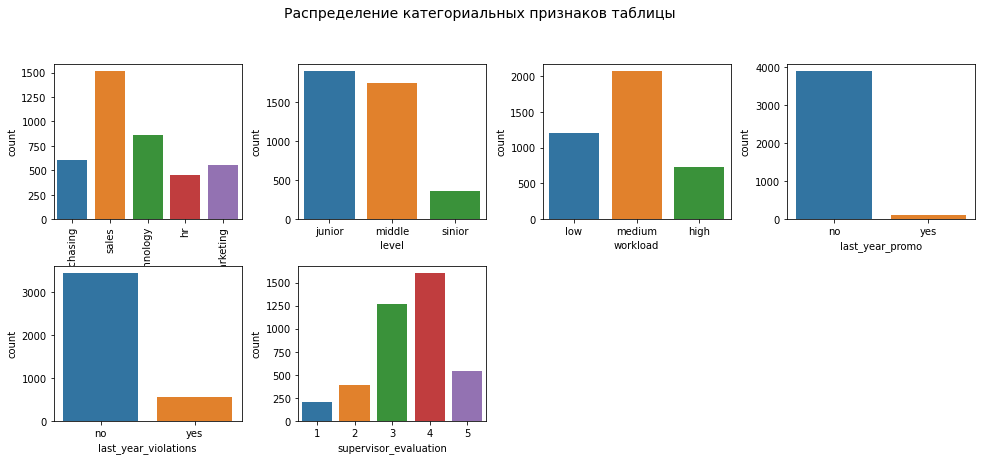

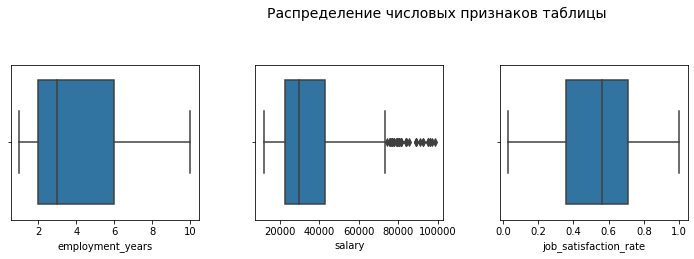

In [32]:
cat_feature_plot(train_job_satisfaction_rate, cat_col_train)
num_feature_plot(train_job_satisfaction_rate, num_col_train)

На графиках категориальных признаков отчетливо видны вышеописанные пропорции в данных. На графиках числовых признаков видно, что в колонке зарплата присутствуют выбросы - это зарплаты от 75000 рублей до 100000 рублей. Таких значений не очень много - порядка 20-30 штук. По остальным числовым признакам выбросов и аномалий нет.

#### 3.2.2 Таблица 'test_features'

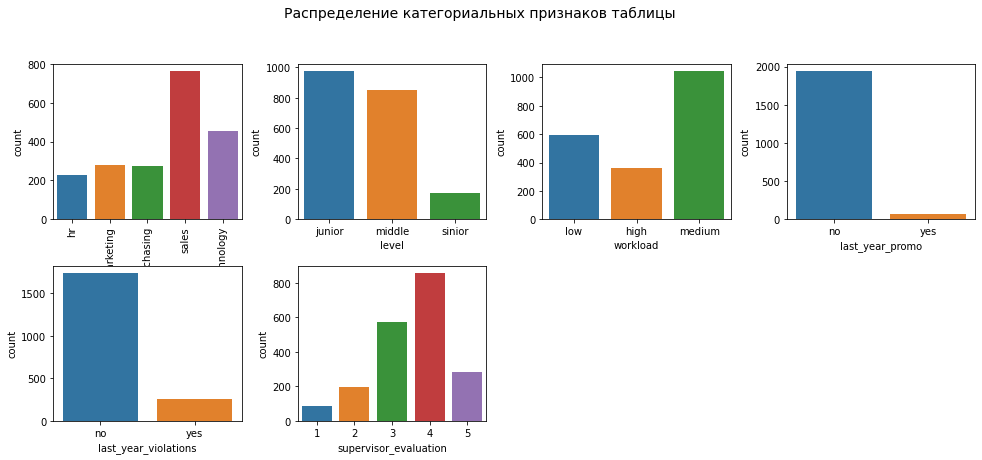

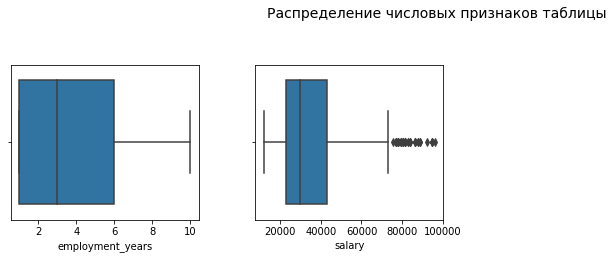

In [33]:
cat_feature_plot(test_features, cat_col_test)
num_feature_plot(test_features, num_col_test)

Опять же, присутсвуют выбросы в колонке 'salary' - это зарплаты от 75000 рублей до 100000 рублей. Таких значений порядка 20 штук.

#### 3.2.3 Таблица 'test_target_job_satisfaction_rate'

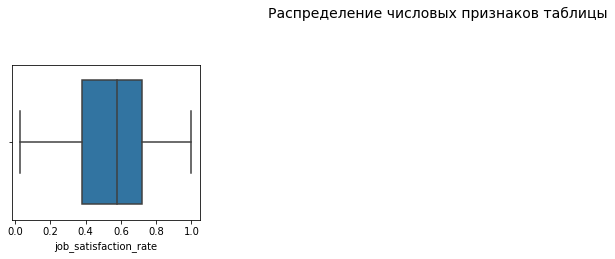

In [34]:
num_feature_plot(test_target_job_satisfaction_rate, ['job_satisfaction_rate'])

Выбросы и аномалии отсутствуют.

### 3.3 Матрица корреляции датафрейма 'train_job_satisfaction_rate'

Будущую модель мы будем обучать на датафрейме 'train_job_satisfaction_rate'. Поэтому рассмотрим матрицу корреляции между всеми признаками этой таблицы. Посколько присутсвтуют категориальные признаки, то для построения матрицы корреляции будем использовать библиотеку phik.

In [35]:
# считаем корреляции нашего датафрейма для всего кроме первой колонки (id)
phik_overview = train_job_satisfaction_rate.phik_matrix(interval_cols=num_col_train)
print(phik_overview.shape)

(9, 9)


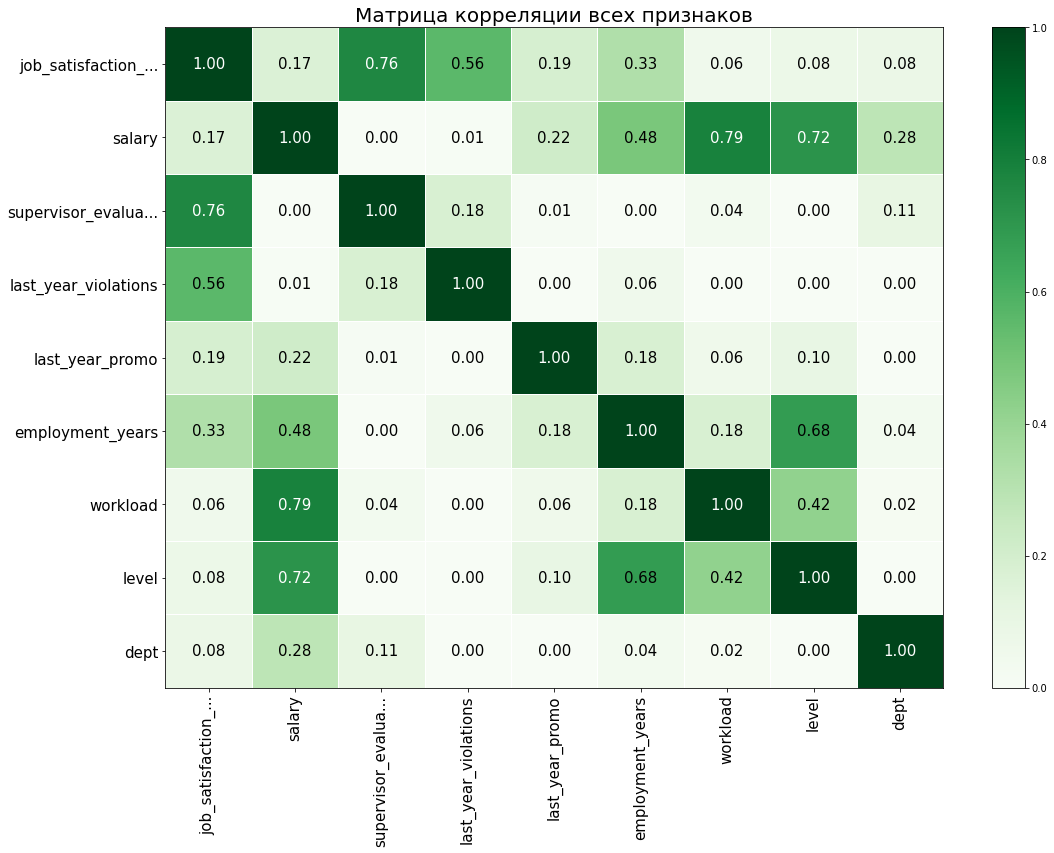

In [36]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(16, 12)
) 
plt.title('Матрица корреляции всех признаков', fontsize = 20)
plt.show()

Мультиколлинеарность между признаками отсутствует. Присутсвует высокая корреляция (0.76) между уровнем удовлетворенности сотрудника и оценкой работы, которую дал руководитель. Чем сотрудник более удовлетворен, тем лучше он делает свою работу, а соответственно руководитель тем выше его оценивает, тут все логично. Также удовлетворенность коррелирует (0.56) с тем, нарушал ли сотрудник трудовой договор. Чем более удовлетворен сотрудник, тем с большей уверенностью можно предположить, что сотрудник не нарушал договор. Помимо этого, высокая корреляция присутсвует между зарплатой и загруженностью (0.79), а также зарплатой и уровнем сотрудника (0.72): чем выше уровень сотрудника и чем больше его занятость, тем больше зарплата. Также достаточно высокая корреляция (0.68) присутсвтует между количеством лет в компании и уровнем: чем дольше сотрудник в компании, тем выше его уровень.

### 3.4 Вывод

В ходе анализа данных были обнаружены сходства в таблицах 'train_job_satisfaction_rate'  и 'test_features'. Распределения признаков примерно равные:
медианный опыт работы сотрудника составляет 3 года, а зарплата 30000 рублей. Распределение по департаментам: 'sales' - около 38%, 'technology' - около 22%, остальные - от 11 до 15 процентов. По уровню сотрудников: примерно равное количество джуниоров (48%) и миддлов (42%). Сеньоры составляют меньшую часть (около 8%). По загруженности - большинсво сотрудников имеют среднюю  или низкую (суммарно более 80%). Высокую имеет около 18%. За последний год зарплата повышалась лишь у 3% сотрудников. Трудовой договор нарушало около 13% сотрудников.

Также были замечены выбросы в таблицах 'train_job_satisfaction_rate'  и 'test_features'. Они наблюдались в значениях зарплаты: это 20-30 значений зарплаты в диапозоне от 75000 до 100000 рублей, что объясняется тем, что в компании присутсвует низкий процент специалистов уровня сеньор, и их зарплаты выбиваются из зарплат всех сотрудников.

Была построена матрица корреляция для таблицы 'train_job_satisfaction_rate'. Мультиколлинеарность между признаками отсутсвует. Присутсвуют логичные корреляции между некоторыми признаками (например: зарплата и загруженность, зарплата и уровень сотрудника).

## 4. Подготовка данных

Для работы нашей будующей модели необходимо подготовить данные. Создадим пайплайн, который будет кодировать категориальные колонки и скалировать непрерывные. Наша модель будет обучаться на датасете 'train_job_satisfaction_rate'. Поэтому пока что будем работать с ним.

Для начала создадим тренировочную выборку.
Затем создадим тестовую выборку.

In [37]:
#создание тренировочной выборки
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
#создание тестовой выборки
X_test = test_features
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']


Далее создадим пайплайн для обработки данных. Будем обрабатывать категориальную неранговую колонку при помощи OneHotEncoder(), категориальные ранговые с помощью OrdinalEncoder(), а непрерывные числовые при помощи MinMaxScaler(). Целовой признак обрабатывать не будем, так как он и так находится в пределах от 0 до 1.

In [38]:
# создаём списки с названиями признаков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories = [
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no'],
                    [1, 2, 3, 4, 5]
                ],                  
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),  
     ('ord', ord_pipe, ord_columns),   
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Выборки подготовлены: присутсвуют тренировочная, валидационная и тестовая. Пайплайн 'data_preprocessor' для предобработки признаков готов. В дальнейшем он войдет в финальный пайплайн, в котором также будет и сама модель.

## 5. Обучение моделей

В качестве моделей мы будем использовать две модели: LinearRegression() и RandomForestRegressor(), будем подбирать для них различные гиперпараметры и найдем лучшую при помощи RandomSearchCV() и метрики SMAPE. Критерием успеха будет считаться результат: SMAPE <= 15 на тестовых данных.

Начнем с написания функции, для расчета метрики SMAPE.

In [39]:
def smape_metric(y_true, y_pred):
    n = len(y_true)
    metric = 100 / n * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    return metric

# создаём пользовательскую метрику
smape = make_scorer(smape_metric, greater_is_better=False)

Теперь создадим пайплайн 'pipe_final', который будет включать в себя пайплайн 'data_preprocessor' по предобработке входных признаков и этап моделирования. А дальше при помощи RandomSearchCV() найдем наиболее подходящую модель с лучшими гиперпараметрами, и высчитаем лучшую метрику SMAPE.

In [40]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  LinearRegression()
    )
])
param_grid = [
  
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели  RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split' : range(2, 20),
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__n_estimators': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=40,
    scoring=smape,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(randomized_search.best_score_))

#предсказания на валидационной выборке
#y_valid_pred = randomized_search.predict(X_valid)
#предсказания на тестовой выборке
y_test_pred = randomized_search.predict(X_test)

#print(f'Метрика SMAPE на валидационной выборке: {smape_metric(y_valid, y_valid_pred)}')
print(f'Метрика SMAPE на тестовой выборке: {smape_metric(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

## 6. Вывод

Получилось, что лучше всего с задачей справилась модель RandomForestRegressor(max_depth=16, max_features=18, min_samples_split=3, n_estimators=77, random_state=42). На тренировочной выборке она показала значение метрики SMAPE = 13.2, а на тестовой еще лучше: SMAPE = 12.3.

Это модель справилась лучше, чем LinearRegression(), так как среди признаков были нелинейные категориальные признаки, а модель LinearRegression() хорошо работает, когда признаки имеют близкую к линейной зависимость от целевого признака.

# Задача 2: предсказание увольнения сотрудника из компании

## 1. Загрузка данных

Загрузим новые данные. Одна из таблиц у нас уже обработана в первой задаче - это 'test_features', поэтому ее мы пока не трогаем, а загружаем и работаем только с таблицами 'train_quit' и 'test_target_quit'

In [41]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('C/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('C/datasets/test_target_quit.csv')

Посмотрим на наши датафреймы.

In [42]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [43]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [44]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [45]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные в таблицах соответствуют описанию. Колонки в датафреймах правильно разделены, имена колонок приведены к змеиному регистру. Значения в колонках представлены подходящими типами данных.

## 2. Предобработка данных

### 2.1 Пропуски и дубликаты

Изучим информацию по каждому датафрейму и внесем изменения, если это нужно.

#### 2.1.1 Датафрейм 'train_quit'

In [46]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Пропуски отсутствуют.

Теперь посмотрим на значения в категориальных колонках, возможно там есть опечатки, и из-за этого создались новые классы. Создадим список из колонок со строковыми значениями и выведем уникальные значения для каждой колонки.

In [47]:
columns = train_quit.select_dtypes(include='object').columns.tolist()
for column in columns:
    print(column, ':', train_quit[column].unique())

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level : ['middle' 'junior' 'sinior']
workload : ['high' 'medium' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']
quit : ['no' 'yes']


Все отлично, опечаток нет.

И теперь проверим наши данные на наличие дубликатов.

In [48]:
train_quit.duplicated().sum()

0

Дубликаты отсутствуют.

#### 2.1.2 Датафрейм 'test_target_quit'

In [49]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

Пропуски отсутствуют.

Теперь посмотрим на значения в колонке 'quit', возможно там есть опечатки, и из-за этого создались новые классы.

In [50]:
test_target_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

Опечаток нет.

In [51]:
test_target_quit.duplicated().sum()

0

Дубликаты отсутствуют.

### 2.2 Смена индексов

Для удобства в дальнейшей работе сделаем колонку 'id' индексом в датафреймах. И отсортируем датафреймы по индексу в порядке возрастания.

In [52]:
train_quit = train_quit.set_index('id').sort_values(by='id')
test_target_quit = test_target_quit.set_index('id').sort_values(by='id')

### 2.3 Вывод

Предобработка данных выполнена. Пропуски и дубликаты в датафреймах отсутствуют. Индексы в таблицах были изменены на колонку 'id'.

## 3. Исследовательский анализ данных

Анализ мы проведем аналогично анализу в 1 задаче. Будем использовать функцию describe() для непрерывных признаков и value_count() для категориальных. А потом при помощи ранее написанных функций cat_feature_plot() и num_feature_plot() визуализируем данные.

### 3.1 Статистический анализ данных

#### 3.1.1 Датафрейм 'train_quit'

In [55]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
100858,sales,junior,medium,2,no,no,4,25200,yes


In [56]:
num_col_train = ['employment_years', 'salary']
cat_col_train = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'quit']

In [57]:
train_quit[num_col_train].describe()

,employment_years,salary
count,4000.000000,4000.000000
mean,3.701500,33805.800000
std,2.541852,15152.415163
min,1.000000,12000.000000
25%,2.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,96000.000000


In [58]:
for column in cat_col_train:
    print(train_quit[column].value_counts(normalize=True))
    print()

sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64

junior    0.48725
middle    0.42350
sinior    0.08925
Name: level, dtype: float64

medium    0.5295
low       0.3020
high      0.1685
Name: workload, dtype: float64

no     0.97175
yes    0.02825
Name: last_year_promo, dtype: float64

no     0.86375
yes    0.13625
Name: last_year_violations, dtype: float64

4    0.41350
3    0.30825
5    0.13000
2    0.09775
1    0.05050
Name: supervisor_evaluation, dtype: float64

no     0.718
yes    0.282
Name: quit, dtype: float64



Медианное время работы в компании составляет 3 года, медианная зарплата 30000 рублей. 

По депортаментам распределение выглядит следующим образом: самым популярным департаментом является 'sales' (36%), за ним идет 'technology' (23%), а на остальные департменты приходится от 11 до 15 процентов. По уровню сотрудников: примерно равное количество джуниоров (48%) и миддлов (42%). Сеньоры составляют меньшую часть (около 9%). По загруженности - большинсво сотрудников имеют среднюю (53%) или низкую (30%). Высокую имеет 17%. За последний год зарплата повышалась лишь у 3% сотрудников. Трудовой договор нарушало около 14% сотрудников. Самая частовстречаемая оценка сотрудников - 4.

#### 3.1.2 Датафрейм 'test_target_quit'

In [59]:
test_target_quit.value_counts(normalize=True)

quit
no      0.718
yes     0.282
dtype: float64

Уволившихся сотрудников меньшая часть от общего числа, и составляет 28%.

### 3.2 Визуализация признаков

#### 3.2.1 Датафрейм 'train_quit'

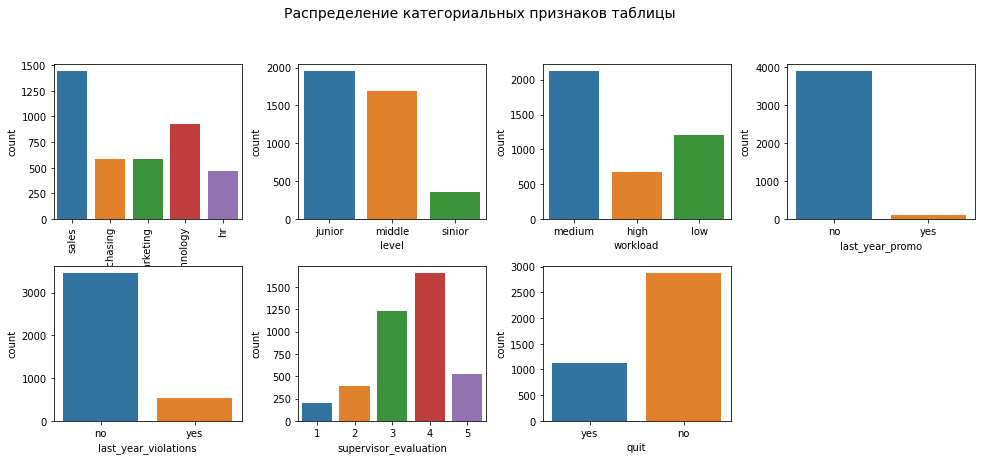

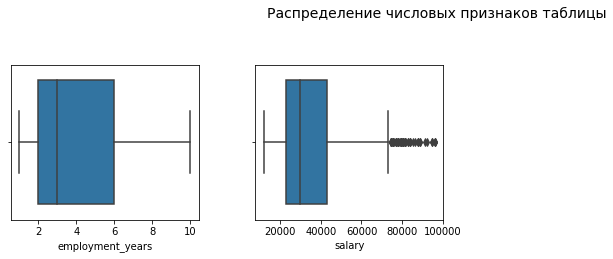

In [60]:
cat_feature_plot(train_quit, cat_col_train)
num_feature_plot(train_quit, num_col_train)

На графиках категориальных признаков отчетливо видны вышеописанные пропорции в данных. На графиках числовых признаков видно, что в колонке зарплата присутствуют выбросы - это зарплаты от 75000 рублей до 100000 рублей. Таких значений не очень много - порядка 20-30 штук. По остальным числовым признакам выбросов и аномалий нет.

#### 3.2.2 Датафрейм 'test_target_quit'

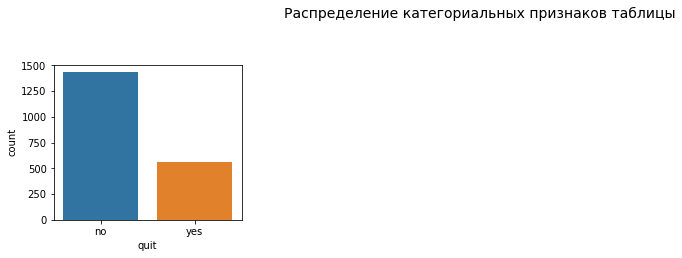

In [61]:
cat_feature_plot(test_target_quit, ['quit'])

### 3.3 Матрица корреляции датафрейма 'train_quit'

Будущую модель мы будем обучать на датафрейме 'train_quit'. Поэтому рассмотрим матрицу корреляции между всеми признаками этой таблицы. Посколько присутсвтуют категориальные признаки, то для построения матрицы корреляции будем использовать библиотеку phik.

In [62]:
# считаем корреляции нашего датафрейма для всего кроме первой колонки (id)
phik_overview = train_quit.phik_matrix(interval_cols=num_col_train)
print(phik_overview.shape)

(9, 9)


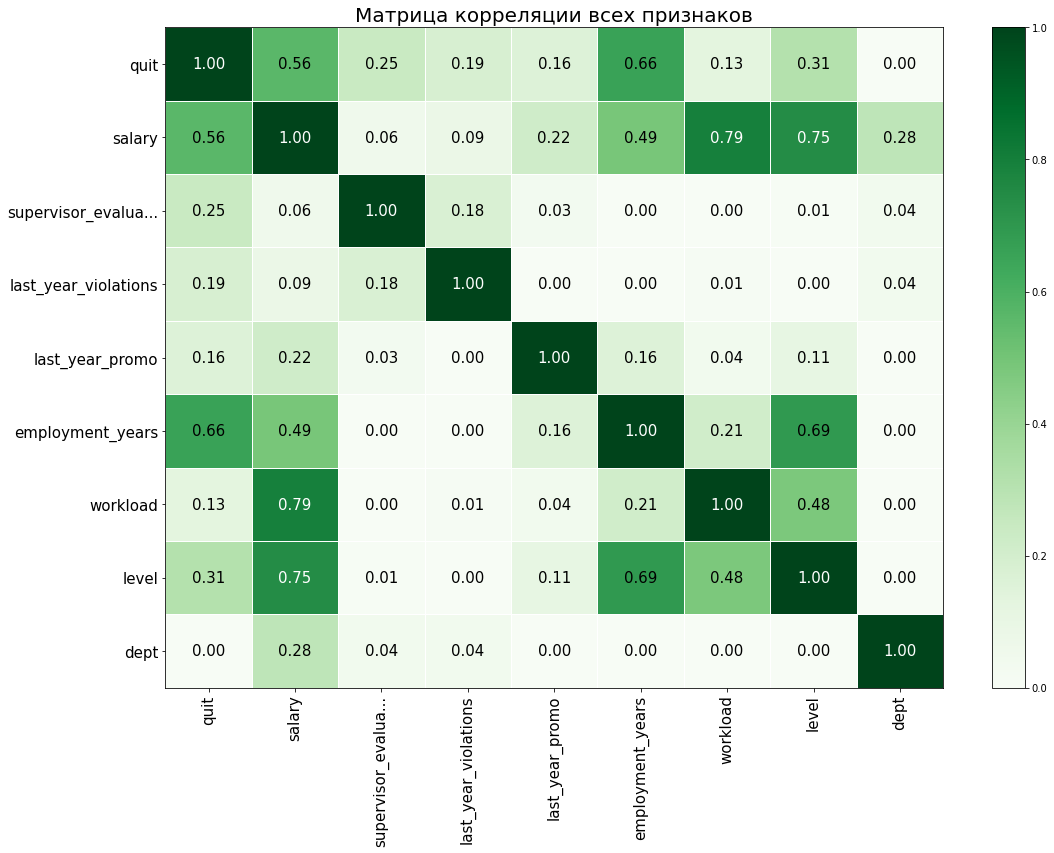

In [63]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(16, 12)
) 
plt.title('Матрица корреляции всех признаков', fontsize = 20)
plt.show()

Мультиколлинеарность между признаками отсутствует. Высокая корреляция присутсвует между зарплатой и загруженностью (0.79), а также зарплатой и уровнем сотрудника (0.75): чем выше уровень сотрудника и чем больше его занятость, тем больше зарплата. Также достаточно высокая корреляция (0.69) присутсвтует между количеством лет в компании и уровнем: чем дольше сотрудник в компании, тем выше его уровень.

### 3.4 Портрет "уволившегося сотрудника"

Составим портрет «уволившегося сотрудника». Посмотрим какой отдел преобладает среди уволившихся сотрудников, какая загруженность у них была, какая оценка от руководства. Создадим новый датафрейм на основе 'train_quit', где будут только уволившиеся сотрудники.

In [64]:
quit = train_quit[train_quit['quit'] == 'yes']
quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
100969,marketing,junior,medium,2,no,no,3,26400,yes
102630,technology,junior,medium,2,no,no,2,30000,yes


Проведем анализ данных нового датафрейма.

In [65]:
quit.describe()

,employment_years,supervisor_evaluation,salary
count,1128.000000,1128.000000,1128.000000
mean,1.844858,3.046099,23885.106383
std,1.274920,0.973291,9351.599505
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,16800.000000
50%,1.000000,3.000000,22800.000000
75%,2.000000,4.000000,27600.000000
max,10.000000,5.000000,79200.000000


In [66]:
for column in cat_col_train:
    print(train_quit[column].value_counts(normalize=True))
    print()

sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64

junior    0.48725
middle    0.42350
sinior    0.08925
Name: level, dtype: float64

medium    0.5295
low       0.3020
high      0.1685
Name: workload, dtype: float64

no     0.97175
yes    0.02825
Name: last_year_promo, dtype: float64

no     0.86375
yes    0.13625
Name: last_year_violations, dtype: float64

4    0.41350
3    0.30825
5    0.13000
2    0.09775
1    0.05050
Name: supervisor_evaluation, dtype: float64

no     0.718
yes    0.282
Name: quit, dtype: float64



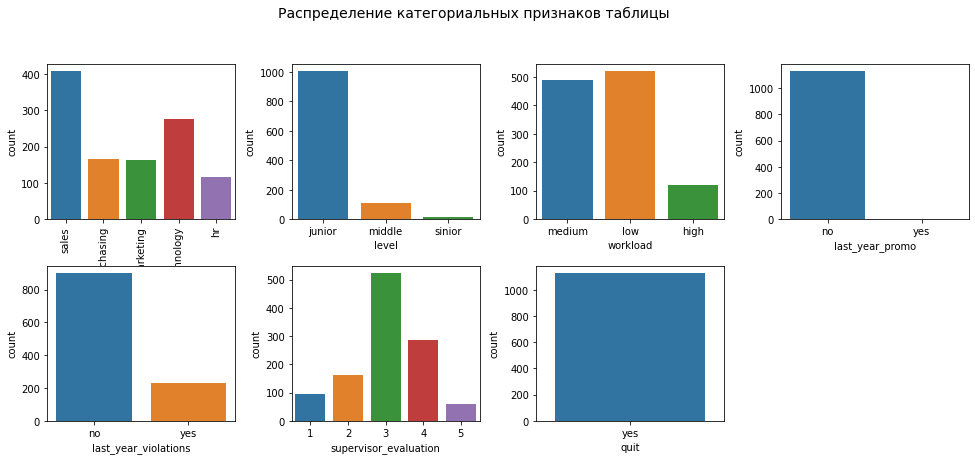

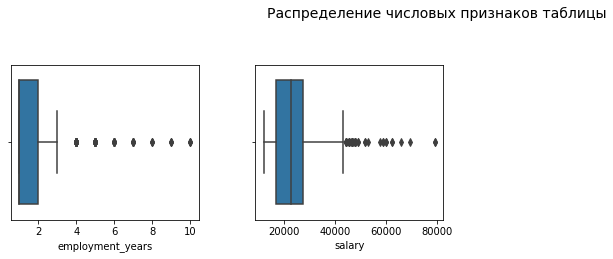

In [67]:
cat_feature_plot(quit, cat_col_train)
num_feature_plot(quit, num_col_train)

Получилось, что от отдела увольнения не зависят. В абсолютных значениях лидирует отдел 'sales', а за ним идет 'technology', но эта пропорция примерно равно общему распределению всех сотрудников по отделам. Так же не зависит увольнение от загруженности, примерно равное количество людей со малой и средней загруженностью (пропорция аналогичная как в датафрейме train_quit). Различия наблюдаются во времени работы и зарплате. Уволившиеся люди, это люди, как правило проработавшие в компании 1 год и имеющие зарплату 22800 рублей. То есть такие, кто только устроился, не понравилось / не справились и они ушли. Присутсвуют некоторые выбросы, т.е. бывает увольняются люди и с зарплатой от 40000 до 80000, люди проработвашие более 4 лет, но это исключения.

### 3.5 Распределения признака 'job_satisfaction_rate' для ушедших и оставшихся сотрудников

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравнним распределения признака 'job_satisfaction_rate' для ушедших и оставшихся сотрудников. Для проверки будем использовать данные с обоими целевыми признаками тестовой выборки.

In [68]:
quit_rate = test_target_job_satisfaction_rate.merge(test_target_quit, on='id', how='inner')

In [69]:
quit_rate.isna().sum()

job_satisfaction_rate    0
quit                     0
dtype: int64

Данные объединили, пропуски отсутсвуют. Теперь посмотрим на распределение рейтинга между теми кто уволился, и теми, кто работает.

In [70]:
quit_rate.head()

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


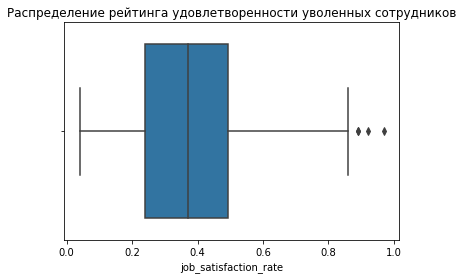

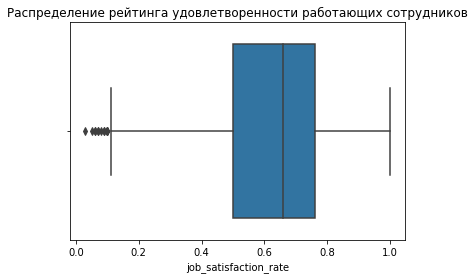

In [71]:
sns.boxplot(data=quit_rate[quit_rate['quit'] == 'yes'], x='job_satisfaction_rate')
plt.title('Распределениe рейтинга удовлетворенности уволенных сотрудников')
plt.show()
sns.boxplot(data=quit_rate[quit_rate['quit'] == 'no'], x='job_satisfaction_rate')
plt.title('Распределениe рейтинга удовлетворенности работающих сотрудников')
plt.show()

Аналитики были правы: уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Медианный рейтинг удовлетворенности уволенных сотрудников составляет чуть менее 0.4. А все значения находятся между 0.2 и 0.5. Есть 3 выброса, но это не критично. У сотрудников же, которые не уволились, медианный рейтинг составяет порядка 0.7, а большинство значений находится между 0.5 и 0.8. То есть разница между группами по рейтингу составляет порядка 0.3, что довольно таки много.

## 4. Добавление нового входного признака

Так как мы выяснили, что признак 'job_satisfaction_rate' влияет на то, уволится сотрудник или нет, добавим этот признак к тренировочному датафрейму 'train_quit' для более точного предсказания. Этот признак был предсказан моделью RandomForestRegressor(max_depth=16, max_features=18, min_samples_split=3, n_estimators=77, random_state=42) в задании 1. Возьмем эту лучшую модель и предскажим на аналогичных данных этот признак для датафрейма 'train_quit' и 'test_features' (чтобы были одинаковые признаки для будущий предсказаний).

In [72]:
train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
100858,sales,junior,medium,2,no,no,4,25200,yes
...,...,...,...,...,...,...,...,...,...
998517,purchasing,middle,low,5,no,no,3,19200,no
999003,hr,middle,low,3,no,no,2,24000,yes
999158,purchasing,junior,medium,1,no,yes,1,21600,yes


In [73]:
train_job_satisfaction_rate

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36
101081,sales,middle,low,2,no,no,4,28800,0.66
101129,technology,junior,medium,1,no,no,4,34800,0.71
...,...,...,...,...,...,...,...,...,...
998223,purchasing,junior,medium,1,no,no,4,28800,0.60
998838,sales,NaN,medium,1,no,no,5,27600,0.71
999264,technology,junior,low,2,no,yes,4,22800,0.73


In [74]:
X_test_2 = train_quit.drop(['quit'], axis=1)
train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_test_2)

In [75]:
X_test_3 = test_features
test_features['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_test_3)

In [76]:
train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.341947
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.327662
100469,marketing,junior,medium,1,no,no,4,28800,no,0.645102
100601,technology,middle,high,4,no,no,4,68400,no,0.666149
100858,sales,junior,medium,2,no,no,4,25200,yes,0.825984
...,...,...,...,...,...,...,...,...,...,...
998517,purchasing,middle,low,5,no,no,3,19200,no,0.370795
999003,hr,middle,low,3,no,no,2,24000,yes,0.237673
999158,purchasing,junior,medium,1,no,yes,1,21600,yes,0.084721


In [77]:
train_job_satisfaction_rate

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36
101081,sales,middle,low,2,no,no,4,28800,0.66
101129,technology,junior,medium,1,no,no,4,34800,0.71
...,...,...,...,...,...,...,...,...,...
998223,purchasing,junior,medium,1,no,no,4,28800,0.60
998838,sales,NaN,medium,1,no,no,5,27600,0.71
999264,technology,junior,low,2,no,yes,4,22800,0.73


## 5. Подготовка данных

Создадим наши проверочную и тестовую выборки.

In [78]:
#создание тренировочной выборки
X_train_final = train_quit.drop(['quit'], axis=1)
y_train_final = train_quit['quit']
#создание тестовой выборки
X_test_final = test_features
y_test_final = test_target_quit['quit']


Будем использовать пайплайн предобработки 'data_preprocessor' из первой задачи, только обновим списки с типами колонок, так как теперь добавился признак 'job_satisfaction_rate'.

In [79]:
# создаём списки с названиями признаков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']

## 6. Обучение модели

В качестве моделей мы будем использовать три модели: DecisionTreeClassifier(), KNeighborsClassifier() и LogisticRegression(). Мы будем подбирать для них различные гиперпараметры и найдем лучшую при помощи RandomSearchCV() и метрики ROC-AUC. Критерием успеха будет считаться результат: ROC-AUC > 91 на тестовых данных.

Теперь создадим пайплайн 'pipe_final_2', который будет включать в себя пайплайн 'data_preprocessor' по предобработке входных признаков и этап моделирования. А дальше при помощи RandomSearchCV() найдем наиболее подходящую модель с лучшими гиперпараметрами, и высчитаем лучшую метрику ROC-AUC.

In [80]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_2 = [
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },    
   
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    n_iter=40,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_2.fit(X_train_final, y_train_final)

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_2.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search_2.predict(X_test_final)
y_test_proba = randomized_search_2.predict_proba(X_test_final)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_final, y_test_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

## 7. Вывод

Получилось, что лучше всего с задачей справилась модель DecisionTreeClassifier(max_depth=5, max_features=8, random_state=42). На тренировочной выборке она показала значение метрики ROC-AUC = 0.926, а на тестовой 0.917, что считается успехом.

Это модель справилась лучше, чем KNeighborsClassifier() и LogisticRegression(), так как среди признаков преобладали категориальные. А при такой структуре дерево решений хорошо себя показывает.

# Общий вывод

## 1. Задача

Перед нами было поставлено две задачи: предсказать уровень удовлетворенности сотрудников компании, а также определить уволится ли сотрудник или нет.

## 2. Этапы работы

Задачи выполнялись поочередно, и в обоих задачах использовались примерно одни и те же этапы.

В начале это загрузка и предобработка данных: мы проверили наличие пропусков, дубликатов, опечаток.

Следующий этап - исследовательский анализ данных. Мы исследовали все признаки в таблицах, посмотрели их распределение, визуализировали их для наглядности. А так же построили матрицу корреляции, чтобы убедиться, что мультиколлинеарность отуствует, а так же для того, чтобы понять как одни признаки влияют на другие.

После этого был создан пайплайн для подготовки данных для дальнейшего моделирования: он включал в себя этапы кодирования категориальных признаков при помощи OneHotEncoder и OrdinalEnocder, а также кодирования непрерывных признаков при помощи MinMaxScaler.

Далее мы подбирали модели и их гиперпараметры, чтобы найти самую лучшую. Качество моделей мы определяли разными метриками. В первой задаче - задаче регрессии - мы использовали модели  LinearRegression и RandomForestRegressor, а метрикой качества служила SMAPE <= 15. Во второй задаче - задаче определения категории - мы использовали модели DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression, а метрикой качества служила ROC-AUC >= 0.91.

После того как были найдены найдены наилучшие модели, мы сделали прогнозы на тестовых данных, и решили задачу заказчика.

## 3. Дополнительные предложения

В ходе анализа данных были найдены закономерности, что увольняются те люди, чей рейтинг удовлетворенности работой составляет около 0.4. А люди же с рейтингом 0.7 остаются на работе. Необходимо работать с сегментом людей с низким рейтингом, чтобы предупредить попытки увольнения. Низкий рейтинг имеют люди с малым опытом работы (1 год) и с медианной зарплатой 22800 рублей. То есть самый тяжелый этап сохранения сотрудника - это первый год. Можно дать рекомендацию, что нужно смотреть именно за молодыми сотрудниками, использоватать различные корпоративы, тимбилдинги и тд.